# Nelder-Mead Generator adapted from SciPy

Most of the algorithms in scipy.optimize are self-contained functions that operate on the user-provided `func`. Xopt has adapted the Nelder-Mead directly from scipy.optimize to be in a generator form. This allows for the manual stepping through the algorithm.


In [1]:
import pandas as pd

from xopt import Xopt
import numpy as np

#from xopt import output_notebook
#output_notebook()

import matplotlib.pyplot as plt

## Nelder-Mead optimization of the Rosenbrock function with Xopt

In [2]:
YAML = """
generator:
  name: neldermead
  initial_point: {x0: -1, x1: -1}
  adaptive: true
  xatol: 0.0001
  fatol: 0.0001  
evaluator:
  function: xopt.resources.test_functions.rosenbrock.evaluate_rosenbrock
vocs:
  variables:
    x0: [-5, 5]
    x1: [-5, 5]
  objectives: {y: MINIMIZE}
"""
X = Xopt.from_yaml(YAML)

In [3]:
XMIN = [1,1] # True minimum

In [4]:
X.run()
X.data

,x0,x1,y,xopt_runtime,xopt_error
0,-1.000000,-1.000000,4.040000e+02,0.000008,False
1,-1.050000,-1.000000,4.462531e+02,0.000007,False
2,-1.000000,-1.050000,4.242500e+02,0.000006,False
3,-0.950000,-1.050000,3.850281e+02,0.000016,False
4,-0.900000,-1.075000,3.589325e+02,0.000006,False
...,...,...,...,...,...
120,0.999935,0.999867,5.114951e-09,0.000006,False
121,0.999877,0.999764,2.587916e-08,0.000006,False
122,0.999999,0.999995,5.309344e-10,0.000006,False
123,1.000045,1.000097,7.751675e-09,0.000007,False


Text(0, 0.5, 'Rosenbrock value')

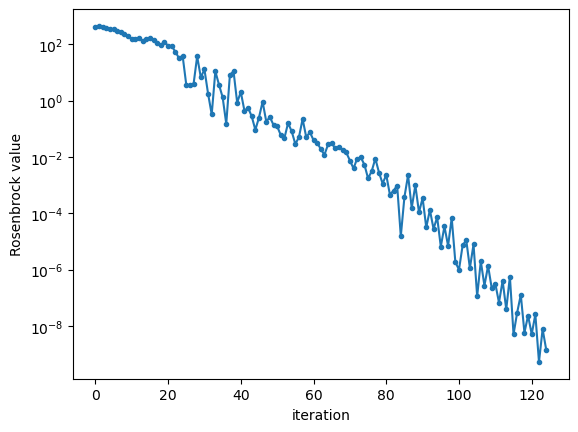

In [5]:
# Evaluation progression
X.data['y'].plot(marker='.')
plt.yscale('log')
plt.xlabel('iteration')
plt.ylabel('Rosenbrock value')

In [6]:
# Minimum
dict(X.data.iloc[X.data["y"].argmin()])

{'x0': 0.9999988592114838,
 'x1': 0.9999954170486077,
 'y': 5.309343918637161e-10,
 'xopt_runtime': 6.3019999743119115e-06,
 'xopt_error': False}

## Visualize

In [7]:
from xopt.resources.test_functions.rosenbrock import rosenbrock

Text(0.5, 1.0, "Xopt's Nelder-Mead progression")

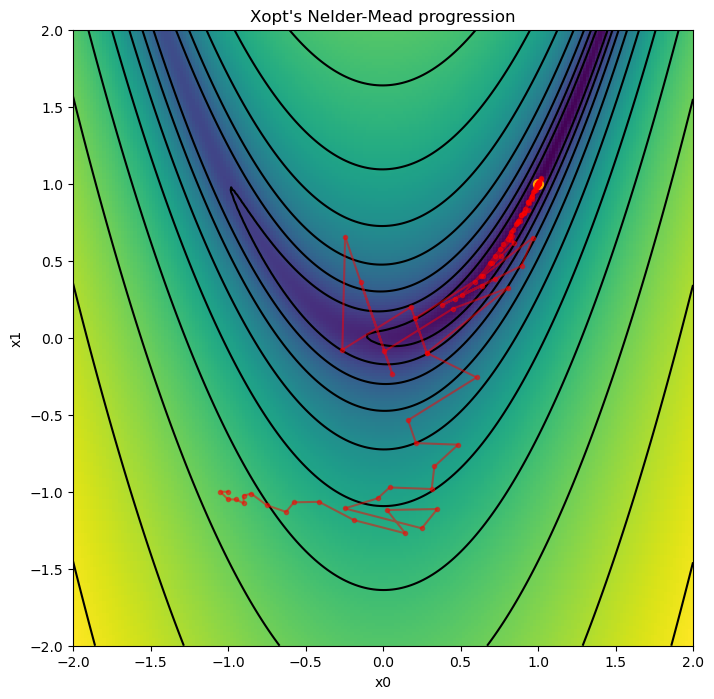

In [8]:
fig, ax = plt.subplots(figsize=(8,8))

Xgrid, Ygrid = np.meshgrid(np.linspace(-2, 2, 201), np.linspace(-2, 2, 201) )

Zgrid = np.vectorize(lambda x, y: rosenbrock([x, y]))(Xgrid, Ygrid)
Zgrid = np.log(Zgrid+1)

ax.pcolormesh(Xgrid, Ygrid, Zgrid)
ax.contour(Xgrid, Ygrid, Zgrid, levels=10, colors='black')
ax.set_xlabel('x0')
ax.set_ylabel('x1')


# Add all evaluations
ax.plot(X.data["x0"], X.data["x1"], color='red', alpha=0.5, marker='.')
ax.scatter(XMIN[0], XMIN[1], 50, marker='o', color='orange', label="True minimum")
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
#plt.legend()
ax.set_title("Xopt's Nelder-Mead progression")

In [9]:
# Manually step the algorithm and collect simplexes
X = Xopt.from_yaml(YAML)
simplexes = []
while not X.generator.is_done:
    X.step()
    simplexes.append(X.generator.simplex)


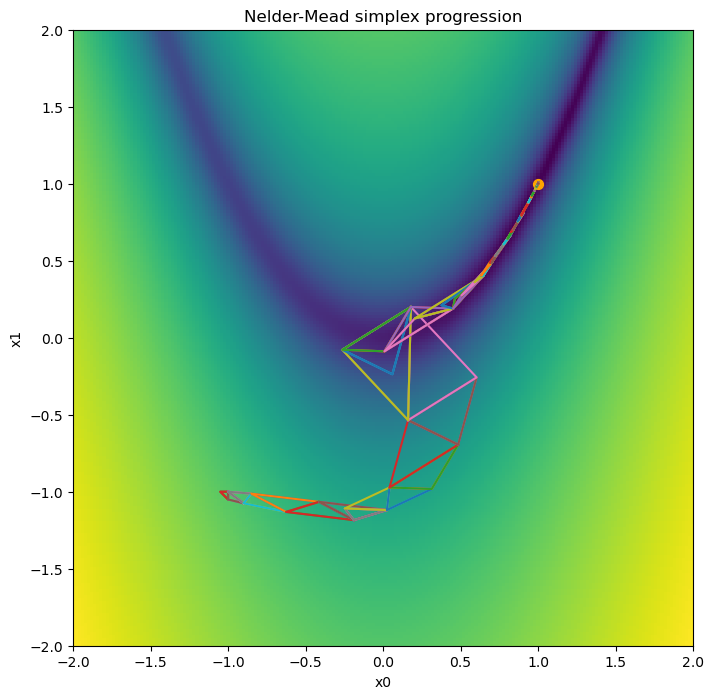

In [10]:
def plot_simplex(simplex, ax=None):
    x0 = simplex["x0"]
    x1 = simplex["x1"]
    x0 = np.append(x0, x0[0])
    x1 = np.append(x1, x1[0])
    ax.plot(x0, x1)

fig, ax = plt.subplots(figsize=(8,8))
ax.pcolormesh(Xgrid, Ygrid, Zgrid)
#ax.contour(Xgrid, Ygrid, Zgrid, levels=10, colors='black')
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)  
ax.set_xlabel('x0')
ax.set_ylabel('x1')
ax.set_title('Nelder-Mead simplex progression')

ax.scatter(XMIN[0], XMIN[1], 50, marker='o', color='orange', label="True minimum")

for simplex in simplexes:
    plot_simplex(simplex, ax)

## Compare with scipy.optimize.fmin Nelder-Mead

Notice that fmin is much faster here. This is because the function runs very fast, so the internal Xopt bookkeeping overhead dominates.


In [11]:
from scipy.optimize import fmin

In [12]:
result = fmin(rosenbrock, [-1, -1])
result

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 67
         Function evaluations: 125


array([0.99999886, 0.99999542])

In [13]:
X = Xopt.from_yaml(YAML)

In [14]:
X.run()
# Almost exactly the same number evaluations. 
len(X.data) 

125

In [15]:
# results are the same
xbest = X.data.iloc[X.data["y"].argmin()]
xbest['x0'] == result[0], xbest['x1'] == result[1]

(True, True)

# NelderMeadGenerator object

In [16]:
from xopt.generators.scipy.neldermead import NelderMeadGenerator
from xopt import Evaluator, VOCS

In [17]:
NelderMeadGenerator.model_fields

{'supports_batch_generation': FieldInfo(annotation=bool, required=False, default=False, description='flag that describes if this generator can generate batches of points', exclude=True, frozen=True),
 'supports_multi_objective': FieldInfo(annotation=bool, required=False, default=False, description='flag that describes if this generator can solve multi-objective problems', exclude=True, frozen=True),
 'vocs': FieldInfo(annotation=VOCS, required=True, description='generator VOCS', exclude=True),
 'data': FieldInfo(annotation=Union[DataFrame, NoneType], required=False, description='generator data', exclude=True),
 'initial_point': FieldInfo(annotation=Union[Dict[str, float], NoneType], required=False),
 'initial_simplex': FieldInfo(annotation=Union[Dict[str, Union[List[float], numpy.ndarray]], NoneType], required=False),
 'adaptive': FieldInfo(annotation=bool, required=False, default=True, description='Change hyperparameters based on dimensionality'),
 'xatol': FieldInfo(annotation=float,

In [18]:
Xbest = [33, 44]

def f(inputs, verbose=False):

    if verbose:
        print(f'evaluate f({inputs})')
    x0 = inputs["x0"]
    x1 = inputs["x1"]
    
    #if x0 < 10:
    #    raise ValueError('test XXXX')

    y = (x0-Xbest[0])**2  + (x1-Xbest[1])**2

    return {"y":y}

ev = Evaluator(function=f)
vocs = VOCS(variables={"x0": [-100, 100], "x1": [-100,100]}, objectives={"y":"MINIMIZE"})
vocs.json()

'{"variables":{"x0":[-100.0,100.0],"x1":[-100.0,100.0]},"constraints":{},"objectives":{"y":"MINIMIZE"},"constants":{},"observables":[]}'

In [19]:
# check output
f(vocs.random_inputs()[0])

{'y': array([4035.03930217])}

In [20]:
G = NelderMeadGenerator(vocs=vocs)
inputs = G.generate(1)
inputs

[{'x0': 27.32652190065714, 'x1': -57.858342831288326}]

In [21]:
# Further generate calls will continue to produce same point, as with BO
G.generate(1)

[{'x0': 27.32652190065714, 'x1': -57.858342831288326}]

In [22]:
ev.evaluate(inputs[0])

{'y': 10407.310358079989,
 'xopt_runtime': 3.4460000506442157e-06,
 'xopt_error': False}

In [23]:
# Adding new data will advance state to next step, and next generate() will yield new point
G.add_data(pd.DataFrame([ev.evaluate(inputs[0])]))
G.generate(1)

[{'x0': 28.69284799569, 'x1': -57.858342831288326}]

In [24]:
# Create Xopt object
X = Xopt(evaluator=ev, vocs=vocs, generator=NelderMeadGenerator(vocs=vocs))

# Optional: give an initial pioint
X.generator.initial_point = {'x0':0, 'x1':0}

In [25]:
X.run()

In [26]:
# Generator is done and cannot be resumed
X.generator.is_done

True

In [27]:
# Generate calls will just return nothing
X.generator.generate(1) is None

True

In [28]:
# This shows the latest simplex
X.generator.simplex

{'x0': array([32.99996111, 32.99996171, 33.00002688]),
 'x1': array([44.00000851, 44.00006811, 44.00003045])}

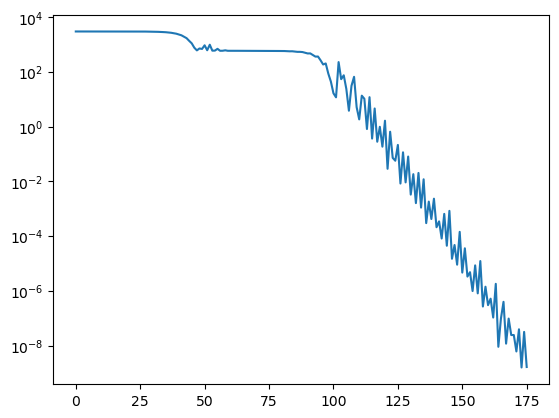

In [29]:
X.data['y'].plot()
plt.yscale('log')

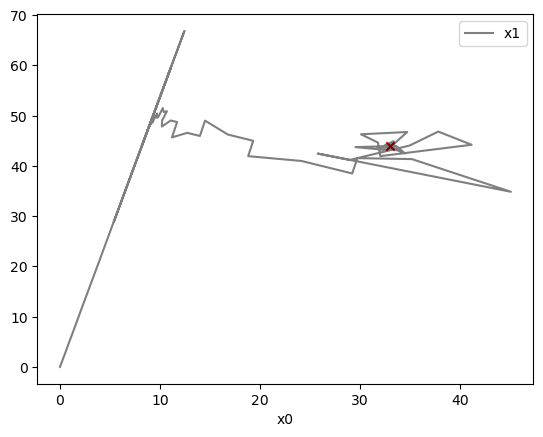

In [30]:
fig, ax = plt.subplots()
X.data.plot('x0', 'x1', ax=ax, color='black', alpha=0.5)
ax.scatter(Xbest[0], Xbest[1], marker='x', color='red')    

In [31]:
# This is the raw internal state of the generator
a = X.generator.current_state
a

SimplexState(astg=4, N=2, kend=3, jend=0, ind=array([2., 0., 1.]), sim=array([[32.99996111, 44.00000851],
       [32.99996171, 44.00006811],
       [33.00002688, 44.00003045]]), fsim=array([1.58463795e-09, 6.10453387e-09, 1.64942323e-09]), fxr=3.1653753661675e-08, x=array(nan), xr=array([32.99983049, 44.00005403]), xe=array([30.09830487, 46.28401515]), xc=array([32.99992966, 44.00013909]), xcc=array([33.00002688, 44.00003045]), xbar=array([32.99996141, 44.00003831]), doshrink=0, ngen=176)

In [32]:
# Check JSON representation of options
X.generator.json()

'{"initial_point":{"x0":0.0,"x1":0.0},"initial_simplex":null,"adaptive":true,"xatol":0.0001,"fatol":0.0001,"current_state":{"astg":4,"N":2,"kend":3,"jend":0,"ind":[2.0,0.0,1.0],"sim":[[32.99996111240644,44.000008508408456],[32.99996171260399,44.0000681073357],[33.00002687564558,44.00003044869291]],"fsim":[1.5846379474430505e-9,6.104533869326014e-9,1.6494232253860804e-9],"fxr":3.1653753661675e-8,"x":null,"xr":[32.99983048622448,44.0000540262304],"xe":[30.098304873214147,46.28401515040761],"xc":[32.99992965625605,44.00013908571843],"xcc":[33.00002687564558,44.00003044869291],"xbar":[32.999961412505215,44.000038307872074],"doshrink":0,"ngen":176},"future_state":null,"x":null,"y":null,"is_done_bool":true}'

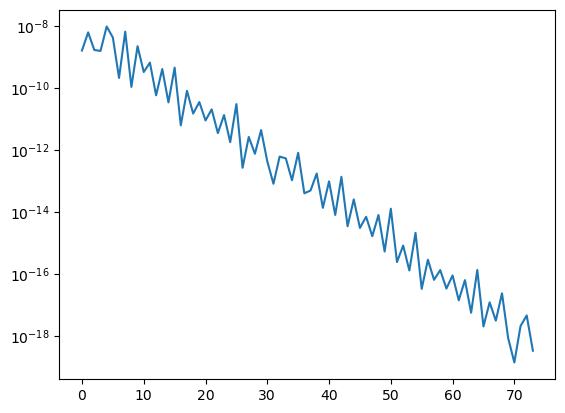

In [33]:
# Set the initial simplex to be the latest
X2 = Xopt(evaluator=ev, vocs=vocs, generator=NelderMeadGenerator(vocs=vocs, initial_simplex=X.generator.simplex))
X2.generator.xatol = 1e-9
X2.generator.fatol = 1e-9
X2.run()

X2.data['y'].plot()
plt.yscale('log')

## 5-dimensional Rosenbrock

`evaluate_rosenbrock` works for arbitrary dimensions, so adding more variables to `vocs` transforms this problem.

In [34]:
YAML = """
generator:
  name: neldermead
evaluator:
  function: xopt.resources.test_functions.rosenbrock.evaluate_rosenbrock
vocs:
  variables:
    x1: [-5, 5]
    x2: [-5, 5]
    x3: [-5, 5]
    x4: [-5, 5]
    x5: [-5, 5]
  objectives:
    y: MINIMIZE
"""
X = Xopt.from_yaml(YAML)

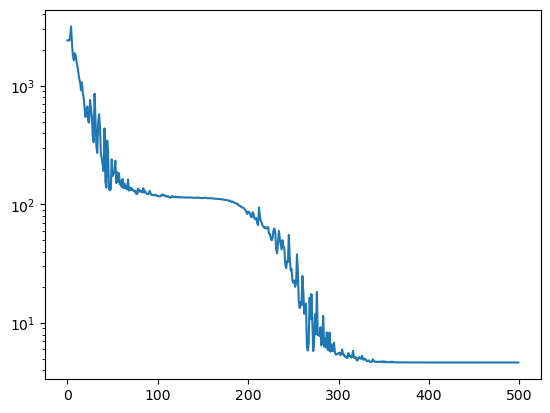

In [35]:
X.run()
X.data['y'].plot()
plt.yscale('log')

Text(0.5, 1.0, "Xopt's Nelder-Mead progression")

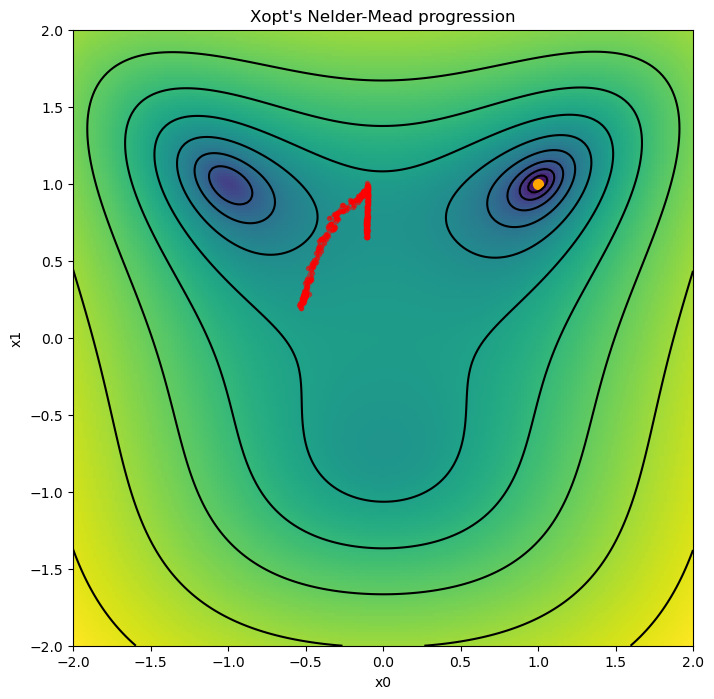

In [36]:
fig, ax = plt.subplots(figsize=(8,8))

Xgrid, Ygrid = np.meshgrid(np.linspace(-2, 2, 201), np.linspace(-2, 2, 201) )

Zgrid = np.vectorize(lambda x, y: rosenbrock([x, y, 1, 1, 1]))(Xgrid, Ygrid)  # The minimum is at 1,1,1,1,1
Zgrid = np.log(Zgrid+1)

ax.pcolormesh(Xgrid, Ygrid, Zgrid)
ax.contour(Xgrid, Ygrid, Zgrid, levels=10, colors='black')
ax.set_xlabel('x0')
ax.set_ylabel('x1')


# Add all evaluations
ax.plot(X.data["x1"], X.data["x2"], color='red', alpha=0.5, marker='.')
ax.scatter(XMIN[0], XMIN[1], 50, marker='o', color='orange', label="True minimum")
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
#plt.legend()
ax.set_title("Xopt's Nelder-Mead progression")